### Projektin tavoite

Vuorokauden aikana taloyhtiön vedenkulutus vaihtelee voimakkaasti, joten energiaa kuluu veden lämmitykseen vaihtelevasti vuorokauden eri tunteina. Koska vesi kiertää lämpimän käyttöveden verkostossa, kuluu osa energiasta  lämpöhäviöihin. Mikäli vedenkulutus pystytään ennustamaan luotettavasti, ajatuksena on, että saavutettaisiin yli 90-95% ennustetarkkuus, voitaisiin lämpimän käyttöveden kierrätys katkaisemaan hetkellisesti, jolloin lämpöhäviöitä ei synny.

Käytetään ennusteen luontiin FB:n Prophet algoritmia. https://facebook.github.io/prophet/docs/quick_start.html


### Valitaan tarvittavat kirjastot

In [1]:
import pandas as pd
from prophet import Prophet
import warnings
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
# Estetään FutureWarning DatetimeProperties.to_pydatetime -metodista
warnings.filterwarnings("ignore", category=FutureWarning)

### Tuodaan malliin data.

Malli edellyttää, että malliin tuotavat sarakkeet on nimetty 'ds' ja 'y', joista ds sisältää aikaleiman ja y on selitettävä muuttuja. ds sisältää aikasarjan kyseessä ollen x-akselin aikaarvot ja y luonnollisesti y-akselin selitettävän muuttujan arvot eli vedenkäytön (m3/h). Poimitaan malliin vain osa aikasarjan tiedoista.

In [2]:
df_water = pd.read_excel('vedenkulutus.xlsx')
df_water['ds']= pd.to_datetime(df_water['ds'])
start_date = '2023-01-01 00:00:00'
end_date = '2024-01-31 23:00:00'
df_water_filtered = df_water[(df_water['ds'] >= start_date) & (df_water['ds'] <= end_date)]

#df_water = df_water[df_water['ds']]
df_water_filtered.tail()
#water.dtypes

,ds,y
41154,2024-01-31 19:00:00,0.49
41155,2024-01-31 20:00:00,0.35
41156,2024-01-31 21:00:00,0.19
41157,2024-01-31 22:00:00,0.17
41158,2024-01-31 23:00:00,0.20


Tarkastellaan dataa.

In [3]:
df_water_filtered.describe()

,ds,y
count,9504,9504.000000
mean,2023-07-17 23:29:59.621211904,0.157345
min,2023-01-01 00:00:00,0.000000
25%,2023-04-09 23:45:00,0.060000
50%,2023-07-17 23:30:00,0.130000
75%,2023-10-24 23:15:00,0.230000
max,2024-01-31 23:00:00,0.850000
std,NaN,0.117775


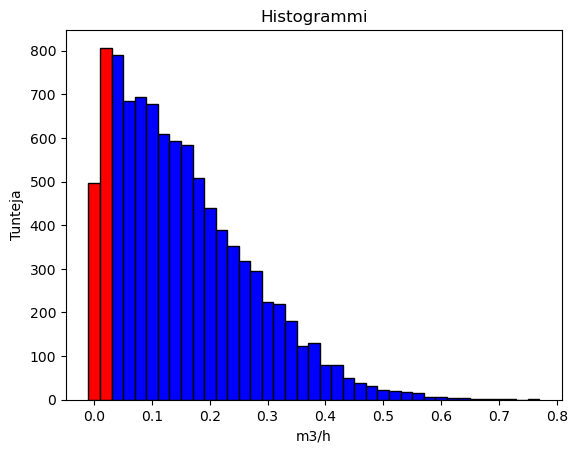

In [4]:
# Assuming df_water['y'] is your data
data = df_water_filtered['y']
bins = [i/50 for i in range(40)]  # [0.02, 0.04, 0.06,...0.8]
# Calculate the histogram manually
hist, bins = np.histogram(data, bins=bins)

# Set colors based on bin values
colors = ['red' if bin_val >= 0 and bin_val <= 0.02 else 'blue' for bin_val in bins]

# Plot the histogram bars
plt.bar(bins[:-1], hist, width=np.diff(bins), color=colors, edgecolor='black')
plt.title('Histogrammi')
plt.xlabel('m3/h')
plt.ylabel('Tunteja')

plt.show()

Kiinnostus koskee vain punaisella merkittyä vedenkulutusta sillä oletuksella, että silloin ei käytetä vettä lainkaan tai käytetään vain kylmää vettä.
Tavoitteena on siis pystyä ennustamaan milloin vedenkulutus osuu niihin.

### Aloitetaan ennusteen tekeminen

In [5]:
# Python
m = Prophet(changepoint_prior_scale=0.001) # luodaan uusi Prophet olio/instanssi. Määritetään hyåeparametrin arvo, joka haettiin iteroimalla.
m.fit(df_water_filtered) #sovitetaan aineisto algoritmiin

15:58:17 - cmdstanpy - INFO - Chain [1] start processing
15:58:17 - cmdstanpy - INFO - Chain [1] done processing


15:58:18 - cmdstanpy - INFO - Chain [1] start processing
15:58:19 - cmdstanpy - INFO - Chain [1] done processing


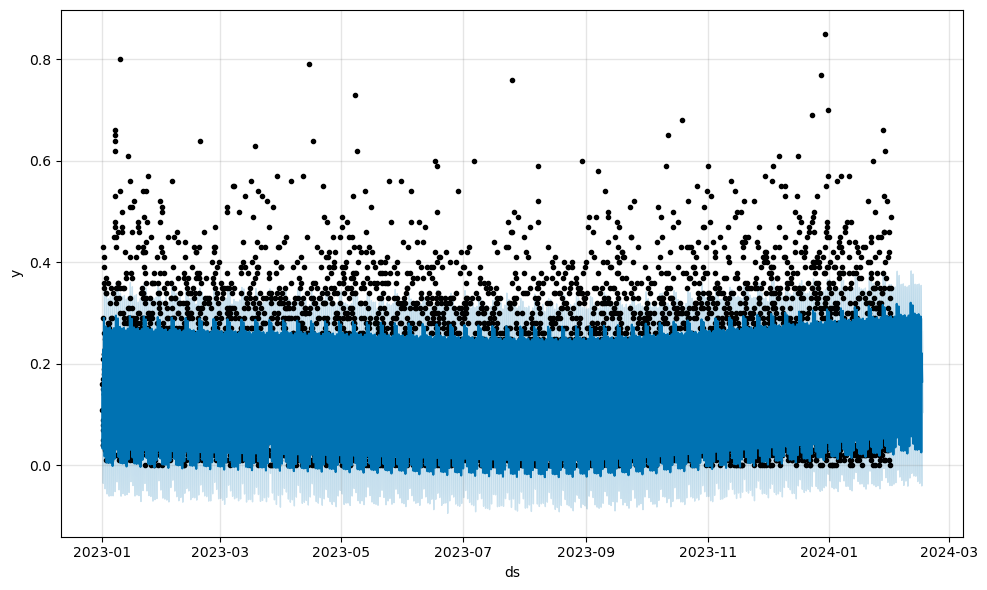

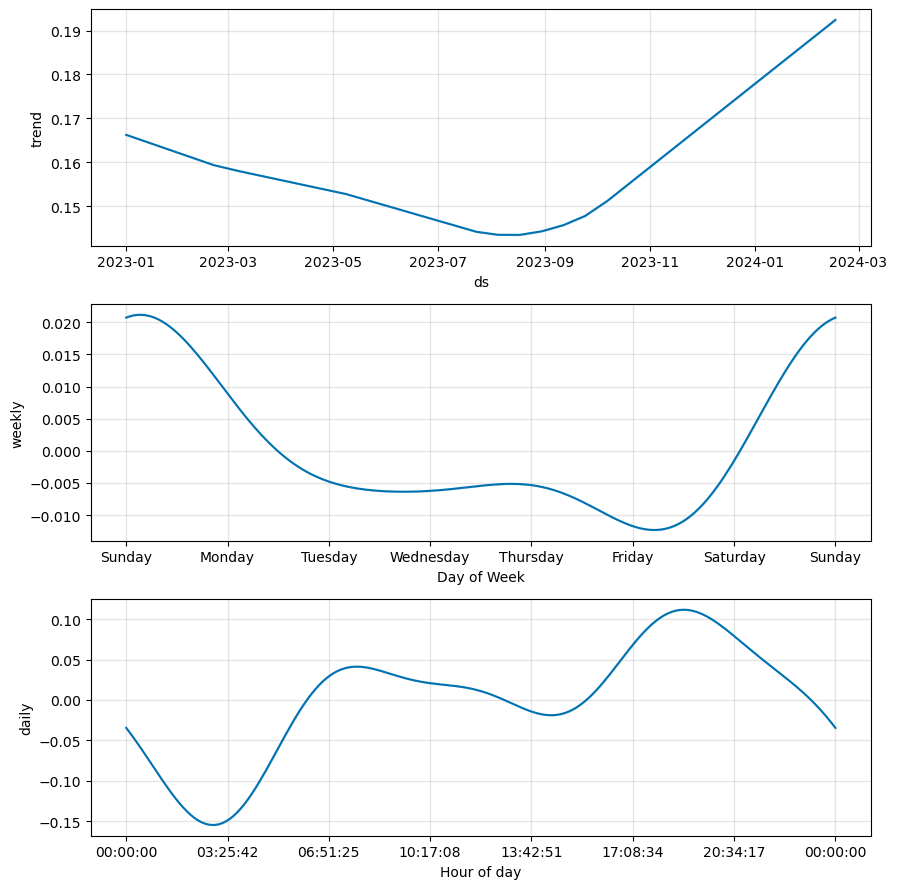

In [6]:
ennuste_m3 = m.make_future_dataframe(periods=375, freq='h') # Tämä luo uuden dataframen, jossa määritellään ennusteperiodi
ennuste_m3['floor'] = 0 # Ennusteen alarajaksi asetetaan 0, koska vedenkäyttö ei voi olla sen alahaisempi
water_forecast = Prophet(interval_width=0.5).fit(df_water_filtered).predict(ennuste_m3)
fig = m.plot(water_forecast)
fig = m.plot_components(water_forecast)

Katsotaan miltä ennuste näyttää

In [7]:
print(water_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())


                      ds      yhat  yhat_lower  yhat_upper
9873 2024-02-16 10:00:00  0.203394    0.139218    0.265077
9874 2024-02-16 11:00:00  0.199195    0.134021    0.265389
9875 2024-02-16 12:00:00  0.192711    0.125154    0.254487
9876 2024-02-16 13:00:00  0.178800    0.112419    0.242500
9877 2024-02-16 14:00:00  0.165453    0.104544    0.233910


In [8]:
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
df_cv = cross_validation(m, horizon='375 hours', initial=0.5)

Seasonality has period of 7 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/49 [00:00<?, ?it/s]

15:58:23 - cmdstanpy - INFO - Chain [1] start processing
15:58:23 - cmdstanpy - INFO - Chain [1] done processing
15:58:23 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
15:58:23 - cmdstanpy - INFO - Chain [1] start processing
15:58:23 - cmdstanpy - INFO - Chain [1] done processing
15:58:23 - cmdstanpy - INFO - Chain [1] start processing
15:58:23 - cmdstanpy - INFO - Chain [1] done processing
15:58:23 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
15:58:23 - cmdstanpy - INFO - Chain [1] start processing
15:58:23 - cmdstanpy - INFO - Chain [1] done processing
15:58:24 - cmdstanpy - INFO - Chain [1] start processing
15:58:24 - cmdstanpy - INFO - Chain [1] done processing
15:58:24 - cmdstanpy - INFO - Chain [1] start processing
15:58:24 - cmdstanpy - INFO - Chain [1] done processing
15:58:24 -

### Arvioidaan mallin suorituskykyä

In [9]:
# Evaluate performance metrics
df_metrics = performance_metrics(df_cv)
print(df_metrics.head(10))

          horizon       mse      rmse       mae     mdape     smape  coverage
0 1 days 13:30:00  0.011137  0.105533  0.074640  0.448244  0.597333  0.821448
1 1 days 14:00:00  0.011223  0.105938  0.074849  0.447189  0.597385  0.819902
2 1 days 14:30:00  0.011292  0.106264  0.075049  0.449998  0.598851  0.819271
3 1 days 15:00:00  0.011385  0.106699  0.075132  0.449998  0.597453  0.819379
4 1 days 15:30:00  0.011556  0.107497  0.075490  0.451582  0.599530  0.819271
5 1 days 16:00:00  0.011680  0.108072  0.075698  0.449719  0.598405  0.819292
6 1 days 16:30:00  0.011743  0.108366  0.075911  0.451219  0.598575  0.816004
7 1 days 17:00:00  0.011716  0.108240  0.075839  0.449891  0.599969  0.816091
8 1 days 17:30:00  0.011834  0.108785  0.076177  0.451582  0.601606  0.813827
9 1 days 18:00:00  0.011858  0.108892  0.076227  0.450448  0.602842  0.812324


In [10]:
df_cv[['ds','y','yhat_lower','yhat','yhat_upper',]].tail()


,ds,y,yhat_lower,yhat,yhat_upper
18370,2024-01-31 19:00:00,0.49,0.146718,0.266217,0.387138
18371,2024-01-31 20:00:00,0.35,0.124994,0.250662,0.379077
18372,2024-01-31 21:00:00,0.19,0.101844,0.222512,0.345052
18373,2024-01-31 22:00:00,0.17,0.077637,0.193820,0.307172
18374,2024-01-31 23:00:00,0.20,0.051432,0.163619,0.282293


In [11]:
# Suodattaa rivit, joissa y on 0.02 tai pienempi
filtered_df = df_cv[df_cv['y'] <= 0.02]
#print(filtered_df.tail(50))

# Laskee niiden tuntien määrän, jolloin yhat on pienempi 0.02 m3/h
count_yhat_greater_than_02 = (filtered_df['yhat'] <= 0.02).sum()

# Lasketaan prosentuaalinen osuus niistä tunneista, jolloin ennuste osuu rajojen sisäpuolelle. Tämä arvo pitäisi olla mahdollisimman suuri.
# Mielellään yli 90%.

percentage = (count_yhat_greater_than_02 / len(filtered_df)) * 100

print(f"Ennuste on pienempi kuin 0.02 {percentage:.2f}% kerroista, kun y on 0.02 tai pienempi.")

Ennuste on pienempi kuin 0.02 53.58% kerroista, kun y on 0.02 tai pienempi.


Iteroinneilla saavutettu maksimiarvo on vain hieman vajaa 54% tunneista, joten Prophetia käyttämällä ennusteella ei kyetä saavuttamaan tavoitetta.
Pitää siis pohtia onko jotain muita tapoja / algoritmeja, jolla tavoiteltava ennustustarkkuus voitaisiin saavuttaa.
Vaihtoehtoisia algoritmeja voisivat olla esim. seuraavat:
1) Autoregressiiviset mallit (AR): Autoregressiivisissa malleissa ennustetaan muuttujan tulevaa arvoa sen aiempien arvojen perusteella. Voit kokeilla esimerkiksi ARIMA (Autoregressive Integrated Moving Average) -mallia. 

2) Koneoppimisen regressiomallit: Lineaariset regressiomallit ja niiden laajennukset voivat olla hyödyllisiä. Voit kokeilla esimerkiksi Support Vector Regression (SVR) tai Random Forest Regression -malleja.

3) Koneoppimisen aikasarjamallit: LSTM (Long Short-Term Memory) ja GRU (Gated Recurrent Unit) ovat syvän oppimisen malleja, jotka sopivat hyvin aikasarjaennustuksiin. Ne voivat oppia monimutkaisia aikasarjojen rakenteita.

4) Keskiarvot ja liukuva keskiarvo: Yksinkertaiset menetelmät, kuten liukuvan keskiarvon käyttäminen, voivat toimia hyvin, erityisesti jos aikasarjassa on selkeitä kausivaihteluja.

5) Eksponentiaalisen tasoituksen mallit: Mallit kuten Holt-Wintersin eksponentiaalinen tasoitus sopivat hyvin aikasarjaennustuksiin ja voivat olla tehokkaita ennustettaessa tulevia arvoja.

Ongelmana on kuitenkin, että data on hyvin satunnaista, jolloin ennustettavuus ei ole korkea. Jos datassa olisi selittäviä muuttujia, niin niiden avulla olisi ehkä mahdollista päästä parempaan ennustettavuuteen kuin puhtaalla aikasarjalla. Tämä harjoitus oli kuitenkin mielekäs sikäli, että sillä pystyi tutustumaan Prophetiiin ja miten sitä voidaan käyttää ennusteen luontiin.  